# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

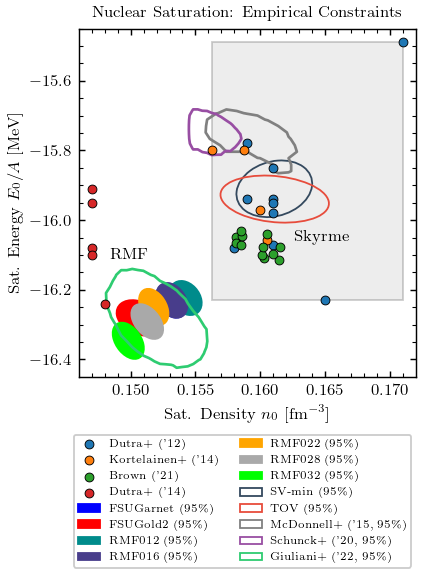

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

 ## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

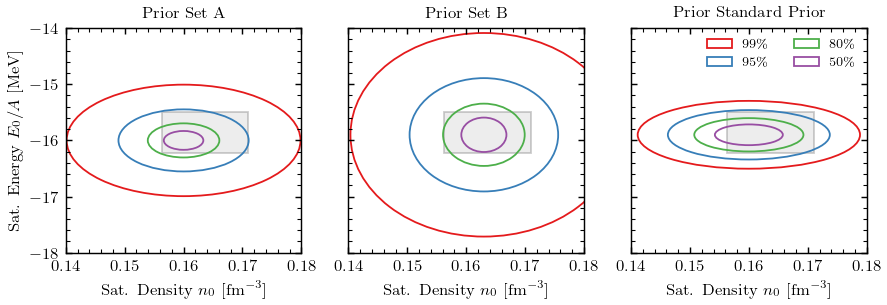

In [3]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("pdf/prior_sets.pdf")

We use the two priors on the left to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)
### Apply our statistical model directly

number of data point(s): 14


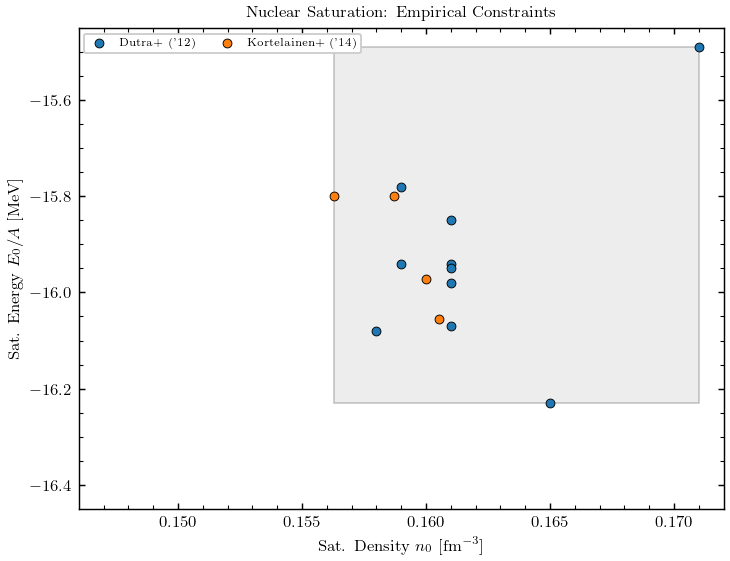

In [4]:
from modules.SaturationAnalysis import drischler_satbox
print(f"number of data point(s):", len(drischler_satbox.data_frame))
drischler_satbox.plot(plot_box_estimate=True, legend_out_of_frame=False)

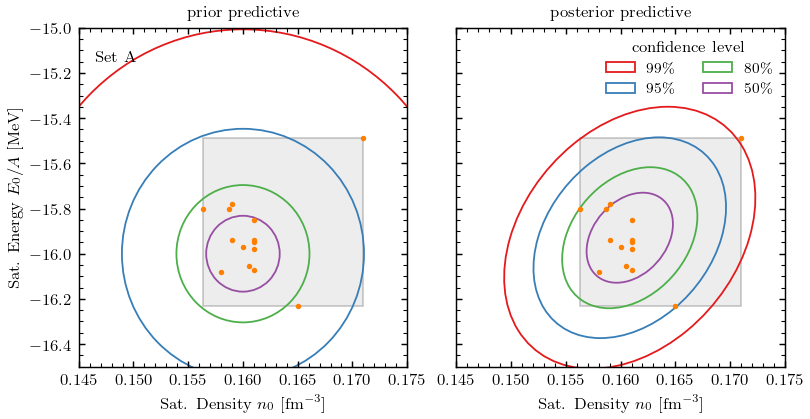

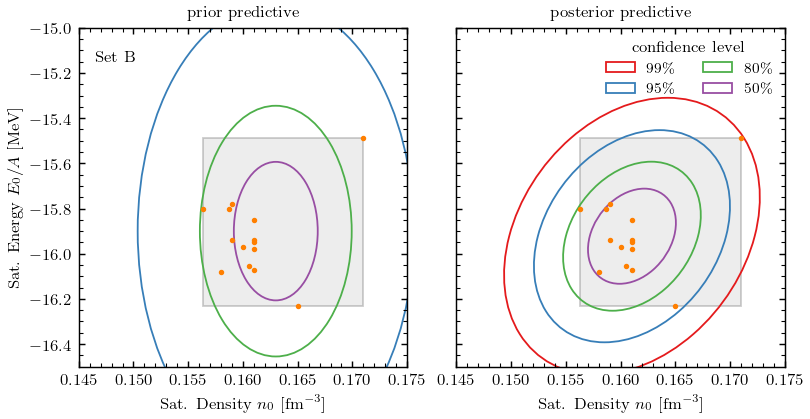

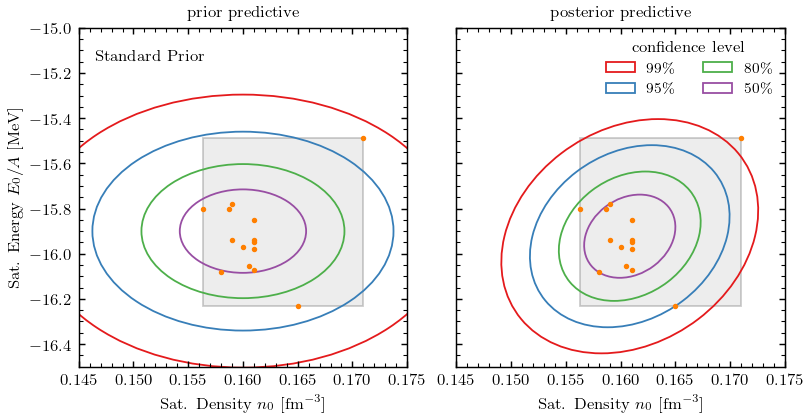

In [5]:
from modules.StatisticalModel import StatisticalModel
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    fig, _ = model.plot_predictives(validate=False)
    fig.savefig(f"pdf/overview_analysis_satbox_{label_filename(prior_set['label'])}.pdf")

Set A (17, array([  0.16083667, -15.9292    ]), array([[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]]))
Set B (17, array([  0.16103667, -15.92253333]), array([[1.11649213e-05, 1.64374170e-04],
       [1.64374170e-04, 3.06951362e-02]]))
Standard Prior (23, array([  0.16083667, -15.92253333]), array([[1.21535505e-05, 1.18358879e-04],
       [1.18358879e-04, 2.37265500e-02]]))


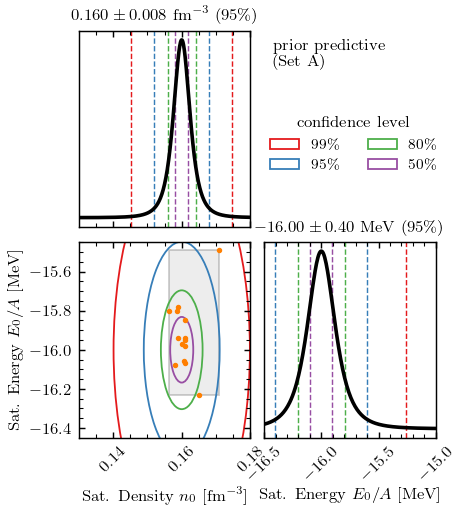

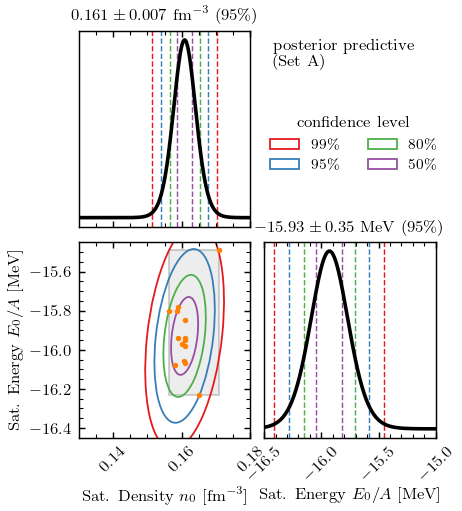

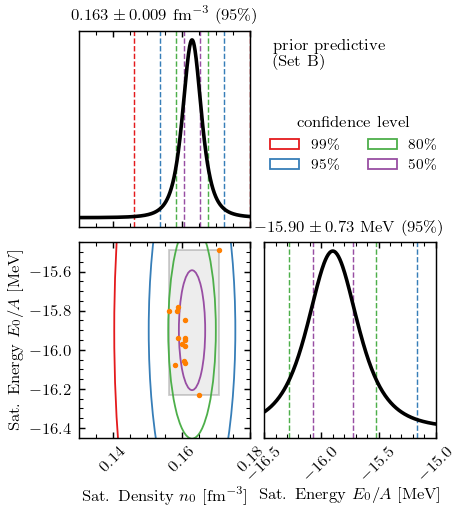

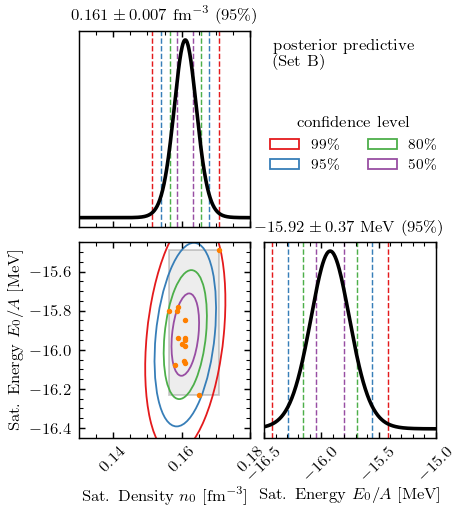

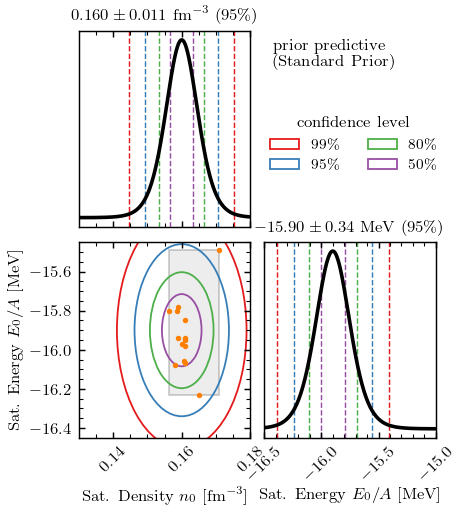

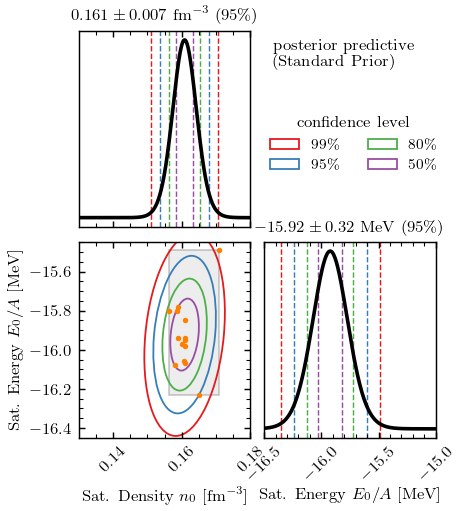

In [6]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.predictives_params())
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

Generating the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

Set A (17, array([  0.16083667, -15.9292    ]), array([[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]]))
Set B (17, array([  0.16103667, -15.92253333]), array([[1.11649213e-05, 1.64374170e-04],
       [1.64374170e-04, 3.06951362e-02]]))
Standard Prior (23, array([  0.16083667, -15.92253333]), array([[1.21535505e-05, 1.18358879e-04],
       [1.18358879e-04, 2.37265500e-02]]))


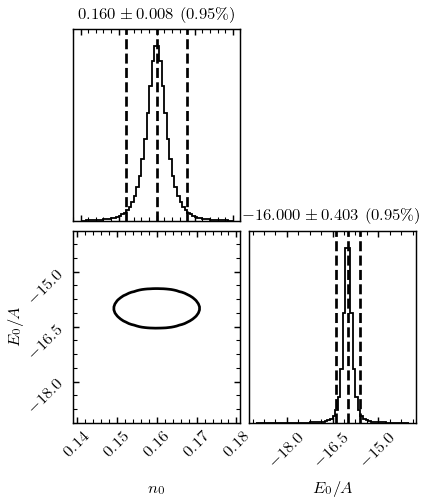

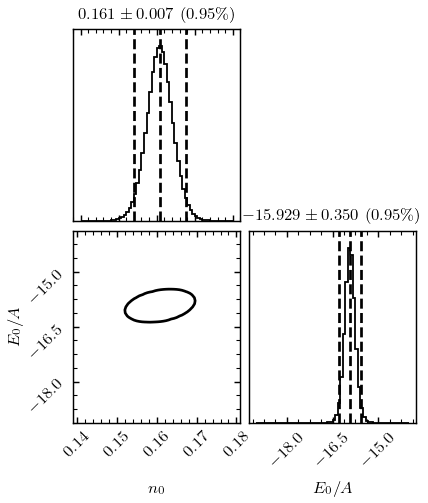

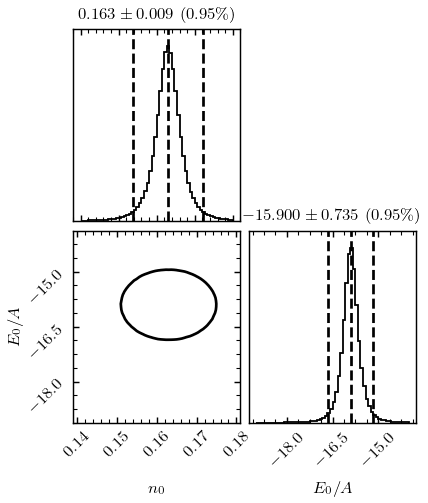

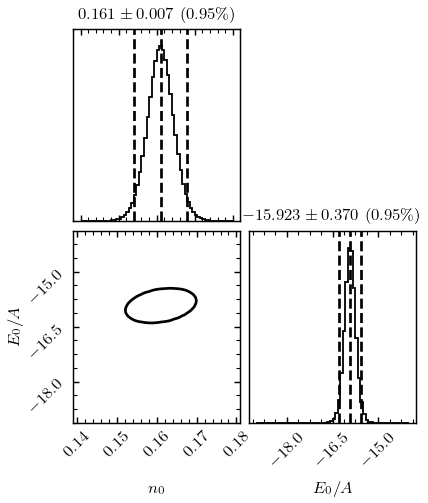

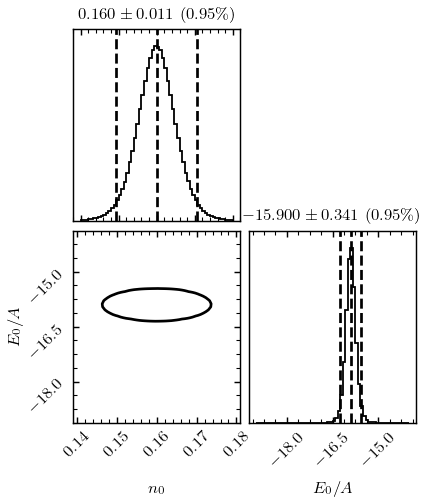

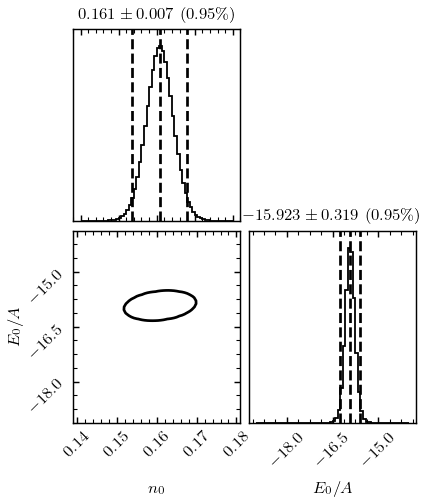

In [7]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner_bf()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_bf_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.predictives_params())
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

The results match. However, the Python package `corner` has a known bug. The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

### Alternative: use a single Monte Carlo step

In [8]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import drischler_satbox

scenarioX = Scenario(
    label="Drischler Satbox",
    datasets=[drischler_satbox]
)
npts = len(scenarioX.datasets[0].data_frame)
for prior_set in used_prior_sets:
    fit = analysis.mc_iterate(
        scenario=scenarioX,
        num_realizations=1,
        num_pts_per_dft_model=1,
        num_samples_mu_Sigma=100000,
        req_num_workers=1,
        sample_replace=True,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)

Number of workers used for mixture model sampling: 1 (max: 10)
Sampling using 1 batches with sizes: [1]
Worker with pid 69527 [SpawnPoolWorker-1 (1,)] initialized.
	Required time for generating all DFT realizations [69527]: 0.000301 s
	Required time for sampling 1 mixture models [69527]: 0.008352 s
Required time for generating all 100000 posterior samples: 3.744461 s
Results written to './pdf/mc_output_1_drischler-satbox_set_a_num_postersamples_100000_num_mciter_1.pdf'
{'mu': array([  0.16049133, -16.03532595]), 'Psi': array([[ 3.83369952e-06, -1.01971856e-05],
       [-1.01971856e-05,  9.81779022e-03]]), 'df': 4.0}
Samples written to './pdf/samples_1_drischler-satbox_set_a_num_postersamples_100000_num_mciter_1.h5'.
Set A {'mu': array([  0.16049133, -16.03532595]), 'Psi': array([[ 3.83369952e-06, -1.01971856e-05],
       [-1.01971856e-05,  9.81779022e-03]]), 'df': 4.0}
Number of workers used for mixture model sampling: 1 (max: 10)
Sampling using 1 batches with sizes: [1]
Worker with pi

## Hierarchical model

In [9]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    datasets=[dft_constraints["fsu_rmf"]]
)
scenario2 = Scenario(
    label="FSU+Schunck-only",
    datasets=[dft_constraints["fsu_rmf"], dft_constraints["schunck"]]
)
scenario3 = Scenario(
    label="all-but-FSU",
    datasets=[dft_constraints[lbl] for lbl in dft_constraints.keys() if lbl != "fsu_rmf"]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    datasets=[dft_constraints["giuliani"], dft_constraints["schunck"]]
)
# scenario1.configs[0].data_set.plot()

In [10]:
for prior_set in [used_prior_sets[0]]:
    fit = analysis.mc_iterate(
        scenario=scenario3,
        num_realizations=100000,
        num_pts_per_dft_model=1,
        num_samples_mu_Sigma=100,
        req_num_workers=10,
        sample_replace=True,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)
    # analysis.plot_individual_models()

Number of workers used for mixture model sampling: 10 (max: 10)
Sampling using 10 batches with sizes: [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
Worker with pid 69625 [SpawnPoolWorker-8 (8,)] initialized.
Worker with pid 69626 [SpawnPoolWorker-9 (9,)] initialized.
Worker with pid 69623 [SpawnPoolWorker-6 (6,)] initialized.
Worker with pid 69624 [SpawnPoolWorker-7 (7,)] initialized.
Worker with pid 69622 [SpawnPoolWorker-5 (5,)] initialized.
Worker with pid 69630 [SpawnPoolWorker-13 (13,)] initialized.
Worker with pid 69629 [SpawnPoolWorker-12 (12,)] initialized.
Worker with pid 69628 [SpawnPoolWorker-11 (11,)] initialized.
Worker with pid 69621 [SpawnPoolWorker-4 (4,)] initialized.
Worker with pid 69627 [SpawnPoolWorker-10 (10,)] initialized.
	Required time for generating all DFT realizations [69626]: 6.847985 s
	Required time for generating all DFT realizations [69630]: 6.744697 s
	Required time for generating all DFT realizations [69625]: 7.318043 s
	Requi

## EFT predictions for the nuclear saturation point

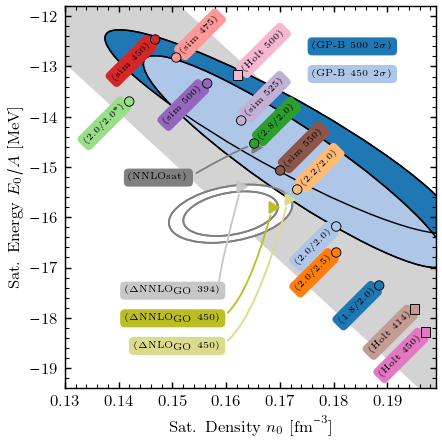

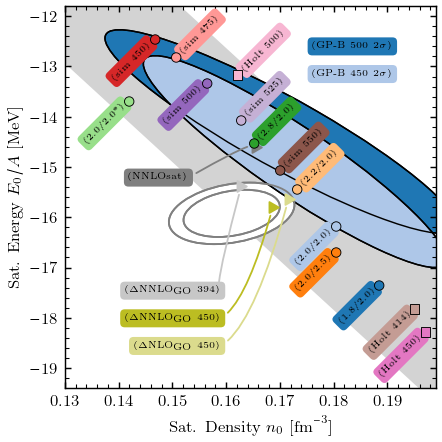

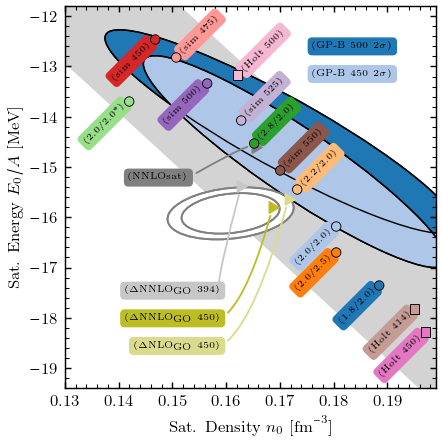

In [11]:
from modules.plot_helpers import cm
import matplotlib.pyplot as plt
from modules.eft_satpoints import make_coester_plot
for prior_set in used_prior_sets:
    fig, ax = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    make_coester_plot(ax,
                      #emp_constraint=drischler_satbox.box_estimate().update({"type": "box"})
                      emp_constraint={"type": "t", **model.predictives_params(return_dict=True)}
                      )
    fig.savefig(f"pdf/eft_satpoints_{label_filename(prior_set['label'])}.pdf")

## Symmetry energy at saturation density

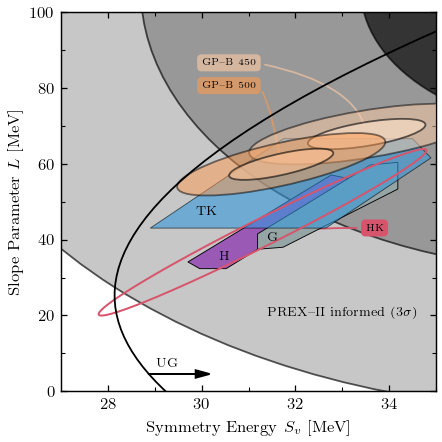

In [12]:
from modules.plot_helpers import cm
from modules.symmetry_energy import make_sv_l_plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
make_sv_l_plot(axs)
fig.savefig("pdf/esym.pdf")